LIBRERIAS Y DATOS

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Configurar TensorFlow para usar solo la CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Define el directorio de la base de datos
directorio = r'C:/Users/joshu/Downloads/JAFFE/JAFFE/jaffedbase/jaffedbase'

# Define el mapeo de emociones a etiquetas numéricas
emociones = {
    'NE': 0,  # Neutral
    'HA': 1,  # Happy
    'SA': 2,  # Sad
    'SU': 3,  # Surprise
    'AN': 4,  # Angry
    'DI': 5,  # Disgust
    'FE': 6   # Fear
}

contenido = os.listdir(directorio)
imagenes = [nombre for nombre in contenido if nombre.endswith('.tiff')]
imagenes_data = []
etiquetas = []

# Cargar imágenes y etiquetas
for nombre_imagen in imagenes:
    partes = nombre_imagen.split('.')
    codigo_emocion = partes[1][:2]  
    etiqueta = emociones.get(codigo_emocion, -1)  # -1 para emociones no definidas
    etiquetas.append(etiqueta)
    
    ruta_imagen = os.path.join(directorio, nombre_imagen)
    imagen_actual = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    imagen_actual = cv2.resize(imagen_actual, (224, 224))
    imagen_rgb = cv2.cvtColor(imagen_actual, cv2.COLOR_GRAY2RGB)
    imagen_rgb = imagen_rgb / 255.0  # Normalizar
    imagenes_data.append(imagen_rgb)

imagenes_data = np.array(imagenes_data)
etiquetas = np.array(etiquetas)

# Separar los datos en conjuntos de entrenamiento y validación
imagenes_train, imagenes_val, etiquetas_train, etiquetas_val = train_test_split(
    imagenes_data, etiquetas, test_size=0.2, random_state=42
)

MODELO HIBRIDO

In [20]:
from tensorflow.keras import layers, models, regularizers, Input
import tensorflow as tf
# Definir la entrada
inputs = Input(shape=(224, 224, 3))

# Bloque de convoluciones separables en profundidad (inspirado en MobileNet)
def depthwise_separable_conv(x, filters, kernel_size=(3, 3), strides=(1, 1)):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Función para crear un bloque denso (Dense Block) mejorado
def dense_block(x, num_layers, growth_rate):
    for i in range(num_layers):
        y = layers.BatchNormalization()(x)
        y = layers.ReLU()(y)
        y = layers.Conv2D(4 * growth_rate, (1, 1), padding='same', activation=None)(y)
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)
        y = layers.Conv2D(growth_rate, (3, 3), padding='same', activation=None)(y)
        x = layers.Concatenate()([x, y])
    return x

# Función para crear una capa de transición
def transition_layer(x, reduction):
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(int(x.shape[-1] * reduction), (1, 1), padding='same', activation=None)(x)
    x = layers.AvgPool2D((2, 2), strides=(2, 2))(x)
    return x

# Primeras capas convolucionales (inspiradas en VGG16)
x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation=None)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Aplicar un bloque de convoluciones separables en profundidad (MobileNet)
x = depthwise_separable_conv(x, filters=64)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque denso (Dense Block)
x = dense_block(x, num_layers=3, growth_rate=16)
x = transition_layer(x, reduction=0.5)

# Aplicar un bloque de convoluciones separables en profundidad (MobileNet)
x = depthwise_separable_conv(x, filters=128)
x = layers.MaxPooling2D((2, 2))(x)

# Capas adicionales para mayor aprendizaje (mejorar capacidad del modelo)
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

# Capas densas con Dropout y regularización L2
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)  # Dropout para prevenir sobreajuste
outputs = layers.Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)


# Construcción final del modelo
model = models.Model(inputs=inputs, outputs=outputs)

# Compilación del modelo con learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Implementar EarlyStopping y reduccion de learning rate en Plateau
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(imagenes_train)

history = model.fit(imagenes_train, etiquetas_train, 
                    validation_data=(imagenes_val, etiquetas_val), 
                    epochs=2000, 
                    batch_size=4,
                    callbacks=[early_stopping])


Epoch 1/2000
43/43 [==============================] - 2s 25ms/step - loss: 5.6281 - accuracy: 0.1412 - val_loss: 5.3358 - val_accuracy: 0.0930
Epoch 2/2000
43/43 [==============================] - 1s 16ms/step - loss: 5.3802 - accuracy: 0.1824 - val_loss: 5.2023 - val_accuracy: 0.0930
Epoch 3/2000
43/43 [==============================] - 1s 16ms/step - loss: 5.0843 - accuracy: 0.2647 - val_loss: 5.1088 - val_accuracy: 0.0930
Epoch 4/2000
43/43 [==============================] - 1s 16ms/step - loss: 4.8371 - accuracy: 0.2706 - val_loss: 5.0361 - val_accuracy: 0.0930
Epoch 5/2000
43/43 [==============================] - 1s 15ms/step - loss: 4.5512 - accuracy: 0.4118 - val_loss: 4.9471 - val_accuracy: 0.0930
Epoch 6/2000
43/43 [==============================] - 1s 16ms/step - loss: 4.3650 - accuracy: 0.4294 - val_loss: 4.8716 - val_accuracy: 0.0930
Epoch 7/2000
43/43 [==============================] - 1s 16ms/step - loss: 4.2005 - accuracy: 0.5529 - val_loss: 4.8537 - val_accuracy: 0.0930

COSAS QUE MEJORAR

Graficar

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_91 (Conv2D)             (None, 112, 112, 32  896         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_112 (Batch  (None, 112, 112, 32  128        ['conv2d_91[0][0]']              
 Normalization)                 )                                                          

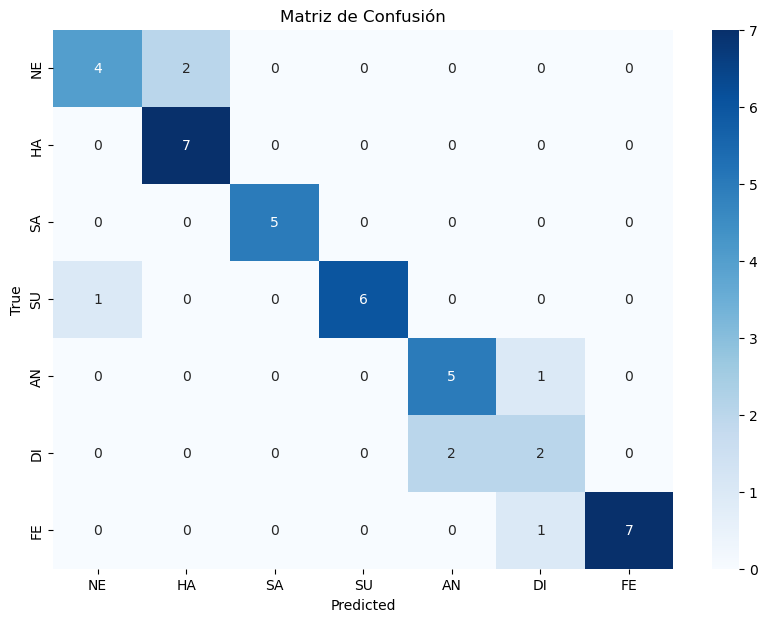

              precision    recall  f1-score   support

          NE       0.80      0.67      0.73         6
          HA       0.78      1.00      0.88         7
          SA       1.00      1.00      1.00         5
          SU       1.00      0.86      0.92         7
          AN       0.71      0.83      0.77         6
          DI       0.50      0.50      0.50         4
          FE       1.00      0.88      0.93         8

    accuracy                           0.84        43
   macro avg       0.83      0.82      0.82        43
weighted avg       0.85      0.84      0.84        43



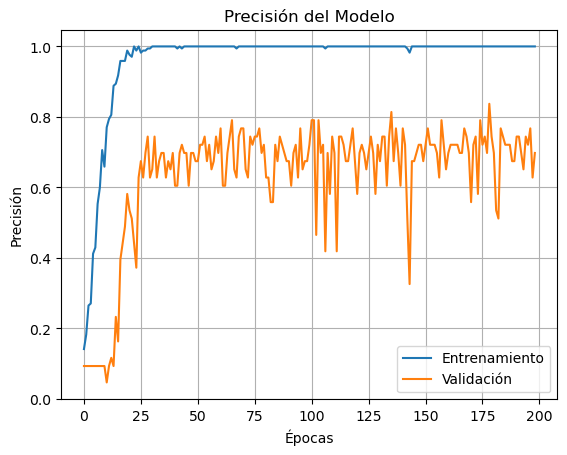

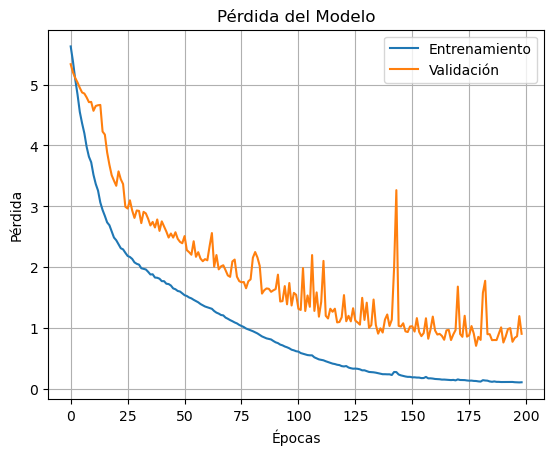

In [22]:
# Resumen del modelo
model.summary()

# Evaluar el modelo en el conjunto de validación
etiquetas_pred = np.argmax(model.predict(imagenes_val), axis=1)

# Generar la matriz de confusión
cm = confusion_matrix(etiquetas_val, etiquetas_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emociones.keys(), 
            yticklabels=emociones.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(etiquetas_val, etiquetas_pred, target_names=emociones.keys()))

# Graficar los resultados de entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from scipy.stats import kurtosis, skew
import cv2
import os
from sklearn.model_selection import train_test_split


# Modelo original
model_input = model.input
layer_outputs = [layer.output for layer in model.layers]  # Obtenemos las salidas de todas las capas
activation_model = Model(inputs=model_input, outputs=layer_outputs)  # Modelo para activaciones

# Escoge una imagen del conjunto de entrenamiento para visualizar
img = imagenes_train[0]  # Puedes cambiar el índice para seleccionar otras imágenes
img = img.reshape(1, 224, 224, 3)  # Cambia el tamaño según la entrada del modelo

# Obtener las activaciones de todas las capas
activations = activation_model.predict(img)

# Visualizar activaciones para cada capa
images_per_row = 8

for layer_name, layer_activation in zip([layer.name for layer in model.layers], activations):
    print(f"Visualizando activaciones para la capa: {layer_name}")
    
    if len(layer_activation.shape) == 4:  # Si la salida es 4D (batch_size, height, width, channels)
        n_features = layer_activation.shape[-1]  # Número de filtros en la capa
        size_y, size_x = layer_activation.shape[1], layer_activation.shape[2]  # Tamaños espaciales

        n_cols = n_features // images_per_row  # Número de columnas para organizar los gráficos
        display_grid = np.zeros((size_y * n_cols, images_per_row * size_x))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()  # Normalizar para mejorar la visualización
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size_y : (col + 1) * size_y,
                             row * size_x : (row + 1) * size_x] = channel_image

        # Visualizar el grid de activaciones
        scale = 1.0 / size_y
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()
    
    elif len(layer_activation.shape) == 2:  # Si la salida es 2D (batch_size, features)
        plt.figure(figsize=(10, 4))
        plt.title(f"Activaciones de la capa {layer_name}")
        plt.plot(layer_activation[0])
        plt.show()

    else:
        print(f"No se puede visualizar la activación de la capa {layer_name} de dimensión {len(layer_activation.shape)}")

# Visualización de pesos para todas las capas
for layer in model.layers:
    try:
        pesos, sesgos = layer.get_weights()

        # Número de filtros en la capa
        num_filtros = pesos.shape[-1]

        # Tamaño del grid para visualizar los filtros
        grid_size = int(np.ceil(np.sqrt(num_filtros)))

        # Visualizar los filtros
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        for i in range(num_filtros):
            filtro = pesos[:, :, 0, i]  # Extrayendo el filtro
            ax = axes[i // grid_size, i % grid_size]
            ax.imshow(filtro, cmap='viridis', aspect='auto')
            ax.axis('off')
        plt.suptitle(f'Pesos de la capa {layer.name}')
        plt.show()
    except:
        # Algunas capas pueden no tener pesos, como MaxPooling2D
        continue

# Cálculo y visualización de estadísticas de pesos para todas las capas
def calcular_entropia(pesos):
    hist, _ = np.histogram(pesos, bins=256, density=True)
    hist += 1e-7  # Evitar log(0)
    return -np.sum(hist * np.log2(hist))

for layer in model.layers:
    try:
        pesos, _ = layer.get_weights()

        # Calcular estadísticas
        media = np.mean(pesos)
        varianza = np.var(pesos)
        asimetria = skew(pesos.flatten())
        curtosis_val = kurtosis(pesos.flatten())
        entropia = calcular_entropia(pesos)
        rango_val = np.ptp(pesos)

        # Mostrar las estadísticas
        print(f"Capa: {layer.name}")
        print(f"  Media: {media}")
        print(f"  Varianza: {varianza}")
        print(f"  Asimetría: {asimetria}")
        print(f"  Curtosis: {curtosis_val}")
        print(f"  Entropía: {entropia}")
        print(f"  Rango: {rango_val}")

        # Graficar la evolución de las estadísticas
        estadisticas = ['Media', 'Varianza', 'Asimetría', 'Curtosis', 'Entropía', 'Rango']
        valores = [media, varianza, asimetria, curtosis_val, entropia, rango_val]

        plt.figure(figsize=(10, 6))
        plt.bar(estadisticas, valores, color='blue')
        plt.title(f'Estadísticas de los Pesos de la Capa {layer.name}')
        plt.ylabel('Valor')
        plt.show()

    except Exception as e:
        print(f"No se pueden calcular los pesos para la capa {layer.name}: {e}")
        continue

